In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import sys
# from pathlib import Path
# sys.path.append(str(Path().resolve().parent / 'src'))

# %load_ext autoreload
# %autoreload 1
# %aimport regressor

## Task 0: Pre-processing

### Loading the data

Our CSV file is unlabeled, so we create our column names following the description in spambase.DOCUMENTATION:

In [4]:
word_freq_names = [f'word_freq_{i}' for i in range(1, 49)]
char_freq_names = [f'char_freq_{i}' for i in range(1, 7)]
cap_run_attr = ['average', 'longest', 'total']

col_names = (
    word_freq_names +
    char_freq_names +
    ['capital_run_length_' + s for s in cap_run_attr] +
    ['spam']
)

In [ ]:
df = pd.read_csv('../data/spambase.data', header=None, names=col_names)
df.head()

,word_freq_1,word_freq_2,word_freq_3,word_freq_4,word_freq_5,word_freq_6,word_freq_7,word_freq_8,word_freq_9,word_freq_10,...,char_freq_1,char_freq_2,char_freq_3,char_freq_4,char_freq_5,char_freq_6,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


### Random Seed

For reproducibility, we'll set the seed for the random generators we use (e.g. for train-test spliiting, stochastic gradient descent, etc...).

In [6]:
rng_seed = 551
rng = np.random.default_rng(seed=rng_seed)

### Train-test split

We'll implement a train-test split of 5-95, that is, we use 5% of the data for training, and hold out the remaining 95% for testing. (In the interest of implementing our classifier from 'scratch', we don't use train_test_split from scikit-learn.)

In [7]:
test_ratio = 0.05
N = len(df)

# Train-test split
df_perm = df.iloc[rng.permutation(N)]
split_index = int(N * test_ratio)
df_train = df_perm.iloc[:split_index]
df_test = df_perm.iloc[split_index:]

X_train = df_train.drop(columns=['spam'])
y_train = df_train['spam']
X_test = df_test.drop(columns=['spam'])
y_test = df_test['spam']

## Task 1: Logistic Regression with SGD

In [8]:
#from regressor import LogisticRegressor

We'll initialize two logistic regressors, one with no regularization and the other with regularization strength 0.001, to compare their loss curves. We'll initialize the remaining hyperparameters to the following values:
- batch_size = 1
- learning_rate = 0.01
- num_epochs = 100

In [9]:
reg_str = 0.001

In [10]:
import warnings
warnings.filterwarnings("error")

In [ ]:
import itertools

# let y^(i)_hat \in [0, 1] be our prediction (a probability)
# that x^{(i)} is a yes-instance of the class.

# For our logistic classifier, y^{(i)}_hat := \sigma(w^T x^{(i)}) 

# The likelihood of our model classifying x^(i) correctly is 
# the Bernoulli(y^{(i)} ; y^(i)_hat)
# = (\hat{y}^{(i)})^{y^{(i)}} * (1 - \hat{y}^{(i)})^{1 - y^{(i)}}

# Thus the negative log likelihood is then 
# - y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)})\log(1 - \hat{y}^{(i)})
    
# This is the objective function of our logistic classifier.
def cross_entropy_loss(pred, y):
    return ( -y * np.log(pred) - (1 - y) * np.log(1 - pred) ).sum()


# A numerically stable implementation of the sigmoid function
# using the "logsumexp" trick
def sigmoid(z):
    # Set c to be the elementwise max of 0 and -z
    c = np.maximum(0, -z)
    
    try:
        return np.exp(-c - np.log(np.exp(-c) + np.exp(-z - c)))
    except RuntimeWarning:
            print('Exponential overflow in sigmoid')


class LogisticRegressor:
    def __init__(self, 
                 batch_size=1,
                 learning_rate=0.01,
                 num_epochs=5,
                 regularization_strength=0,
                 seed=None):
        
        self.batch_size = batch_size
        self.learning_rate=learning_rate
        self.num_epochs=num_epochs
        self.regularization_strength = regularization_strength

        self.rng = np.random.default_rng(seed)
    
    # TODO: implement ADAM
    # TODO: Is it possible to get a fully vectorized implementation
    #       that eliminates the need for the outerloop?
    def fit(self, X, y, learning_curve=False):
        # Concatenate 1's for bias terms
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

        # Add one for bias 
        self.weights = self.rng.random((X.shape[1] + 1, 1))

        if(learning_curve):
            errors = []

        for epoch_count in range(self.num_epochs):
            # Permutation to apply to our rows for stochasticity
            indices = self.rng.permutation(X.shape[0])

            for batch in itertools.batched(indices, self.batch_size):
                # Convert to ndarray to trigger advanced indexing
                ndbatch = np.asarray(batch)
                # Weight update
                try:
                    self.weights = ( 
                        self.weights -
                        self.learning_rate * self.loss_gradient(X[ndbatch], y[ndbatch]) 
                    )
                except TypeError:
                    print('uh oh')


            if(learning_curve):
                try:
                    errors.append(self.loss(X, y))
                except RuntimeWarning:
                    print('Division by 0 in log')

        return errors
    
    # Our loss is the L2-regularized cross entropy loss
    def loss(self, X, y):
        return ( 
            cross_entropy_loss(self.predict(X), y) +
                (self.regularization_strength / 2.0) * (
                        np.linalg.norm(self.weights) ** 2 - self.weights[0] # no bias penalty
                    )
            )
    
    # The gradient of our loss function
    def loss_gradient(self, X, y):
        return ( 
            np.sum(X * (self.predict(X) - y)) + 
            self.regularization_strength * self.weights
        )
    
    # prediction of logistic classifer use the sigmoid function
    def predict(self, X):
        # Concatenate 1 for bias terms
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        return sigmoid(X @ self.weights)

model_no_reg = LogisticRegressor(seed=551)
model_reg = LogisticRegressor(regularization_strength=reg_str, seed=551)

learning_curve_no_reg = model_no_reg.fit(X_train.to_numpy(), y_train.to_numpy(), 
                                         learning_curve=True)
learning_curve_reg = model_reg.fit(X_train.to_numpy(), y_train.to_numpy(), 
                                   learning_curve=True)                 

[[-3.08769175e+02]
 [-4.98101387e+02]
 [-8.26597520e+02]
 [-1.07104448e+03]
 [-2.19866327e+02]
 [-6.85697592e+01]
 [-2.20640314e+02]
 [-1.06374738e+02]
 [-3.57846744e+02]
 [-2.47990649e+04]
 [-2.83094023e+02]
 [-4.08413505e+02]
 [-7.48226421e+02]
 [-1.96351975e+02]
 [-5.80055082e+02]
 [-1.45592971e+02]
 [-2.23106788e+03]
 [-1.25106327e+03]
 [-1.81629552e+02]
 [-2.19299858e+03]
 [-5.18268260e+03]
 [-2.32359036e+03]
 [-2.63111567e+03]
 [-4.49104851e+02]
 [-4.94555585e+02]
 [-5.16395877e+03]
 [-1.22075323e+02]
 [-4.35819190e+02]
 [-3.80005265e+02]
 [-2.47155383e+02]
 [-7.47053378e+01]
 [-7.72497988e+03]
 [-2.31849438e+02]
 [-1.91400878e+02]
 [-1.05950420e+03]
 [-1.41813045e+03]
 [-2.82921152e+02]
 [-5.51914992e+03]
 [-2.69812703e+02]
 [-7.94311300e+01]
 [-4.99831796e+01]
 [-1.32927788e+02]
 [-1.54544086e+03]
 [-1.00841892e+02]
 [-5.86998776e+01]
 [-1.80309756e+02]
 [-3.25900423e+02]
 [-5.10757254e+02]
 [-1.66239004e+01]
 [-3.08640642e+02]
 [-6.71167835e+01]
 [-4.24768699e+02]
 [-1.4251094

[array([nan]), array([nan]), array([nan]), array([nan]), array([nan]), array([nan])]


ValueError: x and y must have same first dimension, but have shapes (5,) and (6, 1)

Error in callback <function _draw_all_if_interactive at 0x72a774cba5c0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

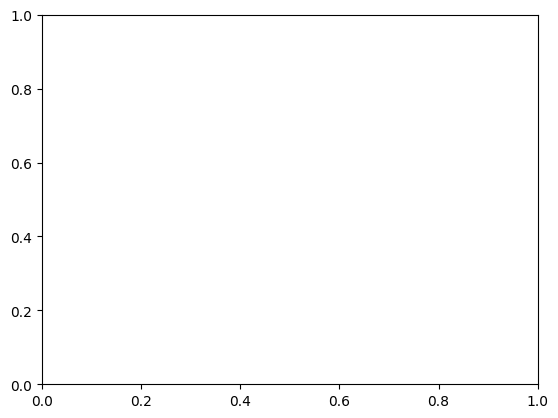

In [ ]:
plt.plot(np.arange(1, model_no_reg.num_epochs + 1), 
            learning_curve_no_reg, 
            'r--', label='\u03BB = 0')
plt.plot(np.arange(1, model_reg.num_epochs + 1),
            learning_curve_reg,
            'b--', label=f'\u03BB = {reg_str}')

plt.xlabel("Epoch") 
plt.ylabel("Cost")
plt.title("Learning Curves")
plt.legend()